In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_excel("276A_Temp.xlsx")

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [4]:
df.dropna(inplace=True)

In [5]:
df.loc['2020-01-20 07:44:00','Temperature on Previous day']=(df.loc['2020-01-20 05:44:00','Temperature on Previous day']+df.loc['2020-01-20 09:44:00','Temperature on Previous day'])/2

In [6]:
df.loc['2020-01-17 17:44:00','Temperature on Previous day']=(df.loc['2020-01-17 15:44:00','Temperature on Previous day']+df.loc['2020-01-17 19:44:00','Temperature on Previous day'])/2

In [7]:
df.loc['2020-01-22 21:44:00','Temperature on Previous day']=(df.loc['2020-01-22 19:44:00','Temperature on Previous day']+df.loc['2020-01-22 23:44:00','Temperature on Previous day'])/2

In [8]:
df[df['Temperature 2 days before']<30]

,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
Date,,,,,,,
2020-01-18 17:44:00,71.5,62.24,66,2020-01-17 17:44:00,70.0,2020-01-16 17:44:00,0.1
2020-01-21 07:44:00,69.5,33.95,42,2020-01-20 07:44:00,70.9,2020-01-19 07:44:00,0.1
2020-01-23 21:44:00,70.5,51.20,54,2020-01-22 21:44:00,70.3,2020-01-21 21:44:00,0.1


In [9]:
df.loc['2020-01-21 07:44:00','Temperature 2 days before']=(df.loc['2020-01-21 05:44:00','Temperature 2 days before']+df.loc['2020-01-21 09:44:00','Temperature 2 days before'])/2

In [10]:
df.loc['2020-01-18 17:44:00','Temperature 2 days before']=(df.loc['2020-01-18 15:44:00','Temperature 2 days before']+df.loc['2020-01-18 19:44:00','Temperature 2 days before'])/2

In [11]:
df.loc['2020-01-23 21:44:00','Temperature 2 days before']=(df.loc['2020-01-23 19:44:00','Temperature 2 days before']+df.loc['2020-01-23 23:44:00','Temperature 2 days before'])/2

In [12]:
df[df['Temperature 2 days before']<30]

,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
Date,,,,,,,


In [13]:
ts=df.loc['1/15/2020':'2/15/2020']['Temperature']
#ts=pd.DataFrame(ts)
ts.tail()

Date
2020-02-15 15:44:00    70.0
2020-02-15 17:44:00    71.3
2020-02-15 19:44:00    71.3
2020-02-15 21:44:00    71.0
2020-02-15 23:44:00    70.9
Name: Temperature, dtype: float64

In [14]:
ts.shape

(384,)

In [15]:
# Create Training and Test
train = ts[:288]
test = ts[288:]

# 1st approach

In [64]:
#building the model
import pmdarima as pm
from pmdarima.arima import auto_arima

model = pm.auto_arima(train.values, start_p=1, start_q=1, seasonal=True, m=12)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: No

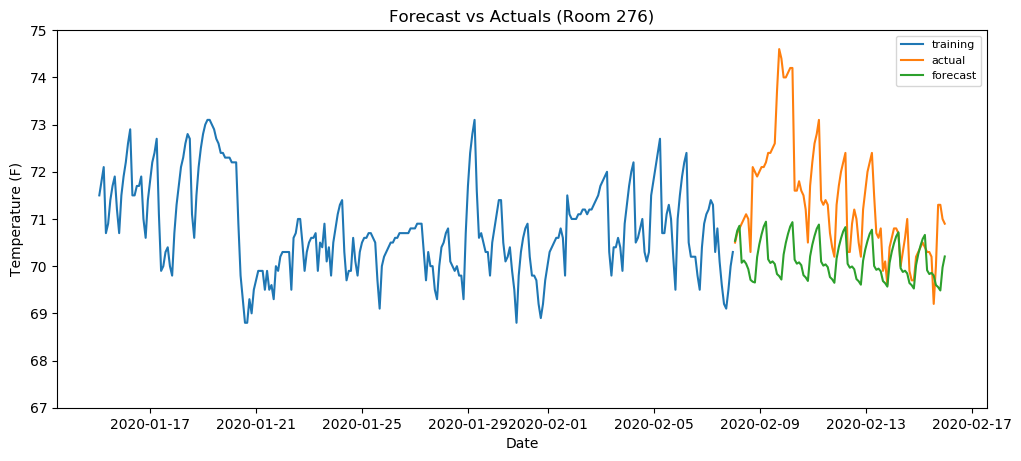

RMSE: 1.6183


In [68]:
# make your forecasts
forecasts = model.predict(96)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:288],train.values, label='training')
plt.plot(ts.index[288:],test.values, label='actual')
plt.plot(ts.index[288:],forecasts, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 276)')
plt.legend(loc='best', fontsize=8)
plt.ylim(67,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

print('RMSE: %.4f'% np.sqrt(sum((test.values-forecasts)**2)/len(forecasts)))

# 2nd approach

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


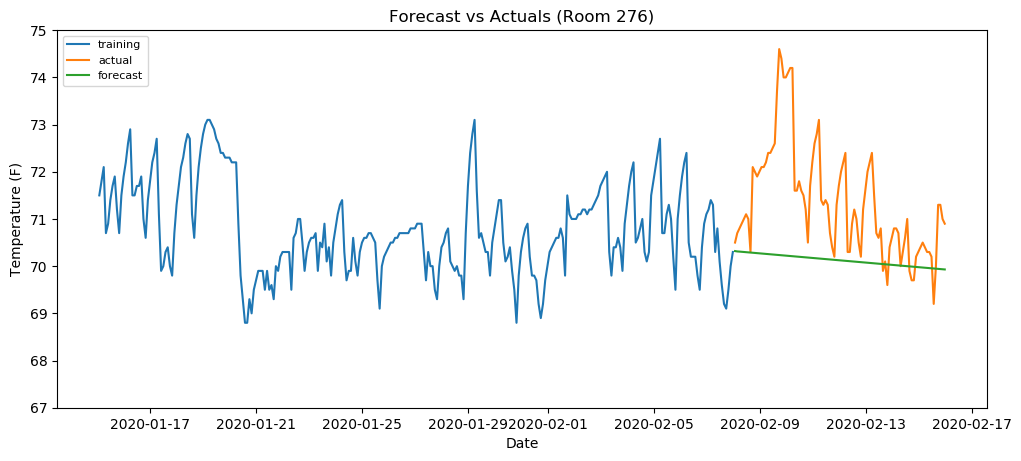

In [69]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(96, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 276)')
plt.legend(loc='upper left', fontsize=8)
plt.ylim(67,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

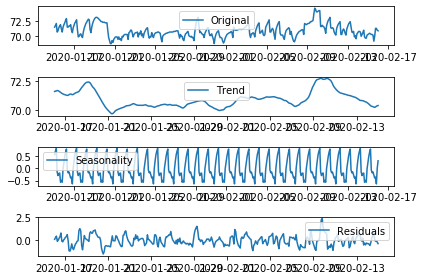

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
print('RMSE: %.4f'% np.sqrt(sum((fc_series-test)**2)/len(fc_series)))

RMSE: 1.6634


# 3rd approach

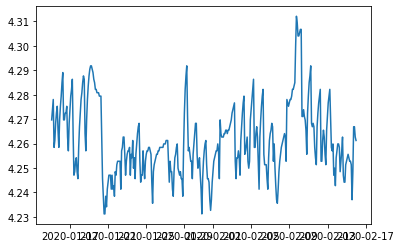

In [22]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

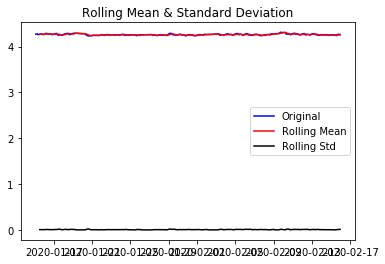

Results of Dickey-Fuller Test:
Test Statistic                  -3.892205
p-value                          0.002093
#Lags Used                      17.000000
Number of Observations Used    366.000000
Critical Value (1%)             -3.448344
Critical Value (5%)             -2.869469
Critical Value (10%)            -2.570994
dtype: float64


In [24]:
test_stationarity(ts_log)

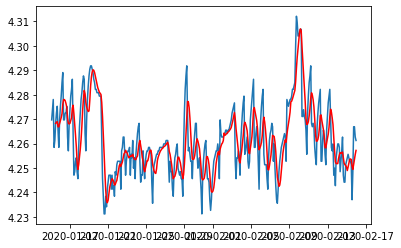

In [25]:
moving_avg = ts_log.rolling(6).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_moving_avg_diff=ts_log-moving_avg
ts_moving_avg_diff.dropna(inplace=True)
ts_moving_avg_diff.head()

Date
2020-01-15 11:44:00    0.000023
2020-01-15 13:44:00    0.003750
2020-01-15 15:44:00    0.006304
2020-01-15 17:44:00   -0.001386
2020-01-15 19:44:00   -0.008433
Name: Temperature, dtype: float64

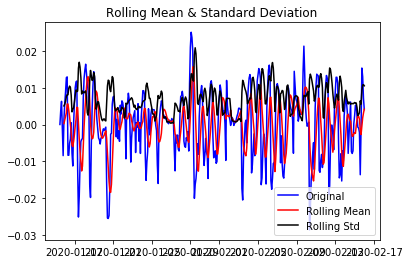

Results of Dickey-Fuller Test:
Test Statistic                  -5.578053
p-value                          0.000001
#Lags Used                      16.000000
Number of Observations Used    362.000000
Critical Value (1%)             -3.448544
Critical Value (5%)             -2.869557
Critical Value (10%)            -2.571041
dtype: float64


In [27]:
test_stationarity(ts_moving_avg_diff)

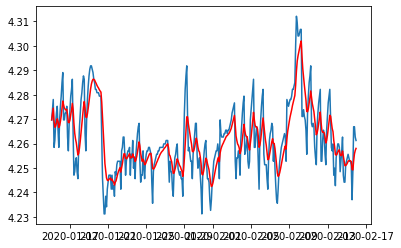

In [28]:
expwighted_avg = ts_log.ewm(halflife=3).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

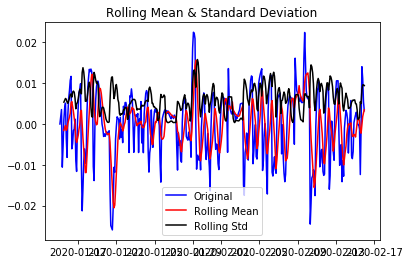

Results of Dickey-Fuller Test:
Test Statistic                -5.778132e+00
p-value                        5.201351e-07
#Lags Used                     1.600000e+01
Number of Observations Used    3.670000e+02
Critical Value (1%)           -3.448294e+00
Critical Value (5%)           -2.869448e+00
Critical Value (10%)          -2.570983e+00
dtype: float64


In [29]:
ts_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_ewma_diff)

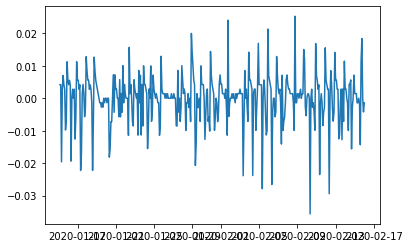

In [30]:
ts_diff=ts_log-ts_log.shift()
plt.plot(ts_diff)

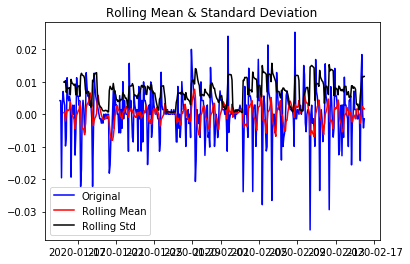

Results of Dickey-Fuller Test:
Test Statistic                -5.815673e+00
p-value                        4.298293e-07
#Lags Used                     1.100000e+01
Number of Observations Used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


In [31]:
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

In [32]:
#ts_diff=ts_diff-ts_diff.shift()
#plt.plot(ts_diff)

In [33]:
#ts_diff.dropna(inplace=True)
#test_stationarity(ts_diff)

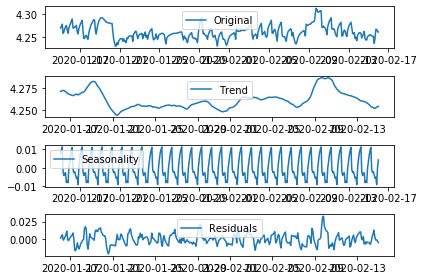

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

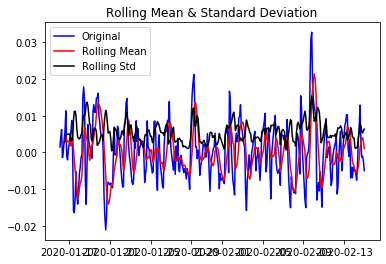

Results of Dickey-Fuller Test:
Test Statistic                -6.946044e+00
p-value                        9.966356e-10
#Lags Used                     9.000000e+00
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [35]:
ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

In [36]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [37]:
lag_acf = acf(ts_diff, nlags=6)
lag_pacf = pacf(ts_diff, nlags=6, method='ols')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


Text(0.5, 1.0, 'Autocorrelation Function')

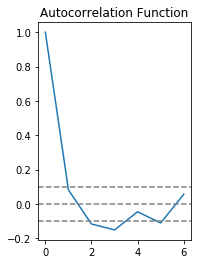

In [38]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

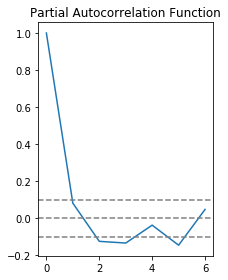

In [39]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [40]:
from statsmodels.tsa.arima_model import ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0231')

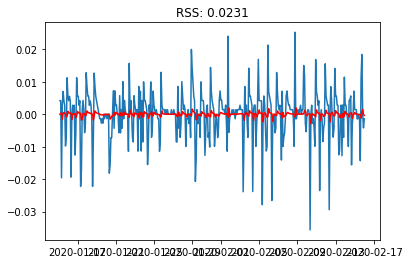

In [41]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)
a=results_AR.fittedvalues
a.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(a, color='red')
plt.title('RSS: %.4f'% sum((a-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0231')

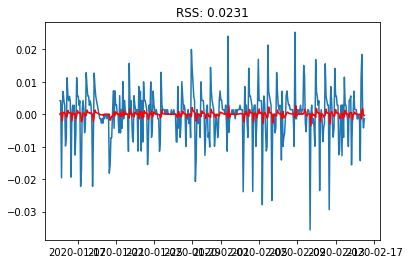

In [42]:
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)
b=results_MA.fittedvalues
b.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(b, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 2H will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0230')

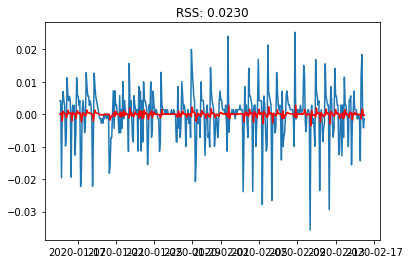

In [43]:
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
c=results_ARIMA.fittedvalues
c.index=ts_diff.index
plt.plot(ts_diff)
plt.plot(c, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

In [44]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  383
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1317.712
Method:                       css-mle   S.D. of innovations              0.008
Date:                Thu, 07 May 2020   AIC                          -2627.423
Time:                        14:13:03   BIC                          -2611.631
Sample:                    01-15-2020   HQIC                         -2621.159
                         - 02-15-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.186e-05      0.000     -0.051      0.959      -0.001       0.001
ar.L1.D.Temperature    -0.2000      0.225     -0.888      0.374      -0.641       0.241
ma.L1.D.Temperat

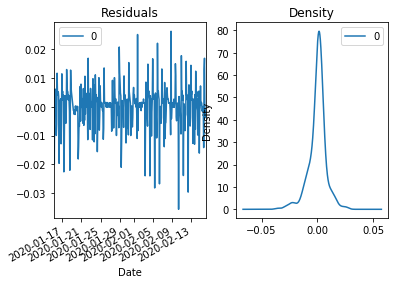

In [45]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [46]:
#results_ARIMA.plot_predict(dynamic=False)
#plt.show()

In [ ]:
#AR forecast

In [47]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff.head()

Date
2020-01-15 03:44:00   -0.000021
2020-01-15 05:44:00    0.000320
2020-01-15 07:44:00    0.000318
2020-01-15 09:44:00   -0.001608
2020-01-15 11:44:00    0.000209
dtype: float64

In [48]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_diff_cumsum.head()

Date
2020-01-15 03:44:00   -0.000021
2020-01-15 05:44:00    0.000298
2020-01-15 07:44:00    0.000617
2020-01-15 09:44:00   -0.000992
2020-01-15 11:44:00   -0.000783
dtype: float64

In [49]:
predictions_AR_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:44:00    4.269697
2020-01-15 03:44:00    4.269676
2020-01-15 05:44:00    4.269996
2020-01-15 07:44:00    4.270314
2020-01-15 09:44:00    4.268705
dtype: float64

Text(0, 0.5, 'Temperature (F)')

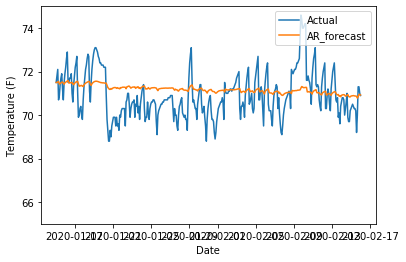

In [50]:
predictions_AR = np.exp(predictions_AR_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_AR,label='AR_forecast')
plt.legend(loc="upper right")
plt.ylim(65,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [51]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_AR-ts)**2)/len(ts)))

RMSE: 1.0224


In [52]:
#MA forecast

In [53]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_MA_diff.head()

Date
2020-01-15 03:44:00   -0.000021
2020-01-15 05:44:00    0.000400
2020-01-15 07:44:00    0.000360
2020-01-15 09:44:00   -0.002039
2020-01-15 11:44:00    0.000470
dtype: float64

In [54]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA_diff_cumsum.head()

Date
2020-01-15 03:44:00   -0.000021
2020-01-15 05:44:00    0.000378
2020-01-15 07:44:00    0.000738
2020-01-15 09:44:00   -0.001301
2020-01-15 11:44:00   -0.000831
dtype: float64

In [55]:
predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:44:00    4.269697
2020-01-15 03:44:00    4.269676
2020-01-15 05:44:00    4.270076
2020-01-15 07:44:00    4.270435
2020-01-15 09:44:00    4.268396
dtype: float64

Text(0, 0.5, 'Temperature (F)')

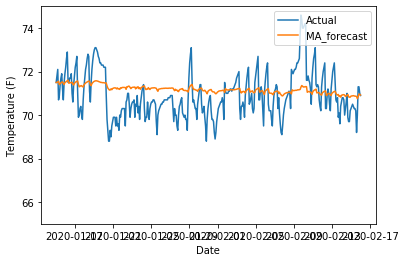

In [56]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_MA,label='MA_forecast')
plt.legend(loc="upper right")
plt.ylim(65,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [57]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))

RMSE: 1.0110


In [ ]:
#ARIMA forecast

In [58]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
2020-01-15 03:44:00   -0.000022
2020-01-15 05:44:00    0.000384
2020-01-15 07:44:00    0.000273
2020-01-15 09:44:00   -0.002058
2020-01-15 11:44:00    0.000871
dtype: float64

In [59]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
2020-01-15 03:44:00   -0.000022
2020-01-15 05:44:00    0.000362
2020-01-15 07:44:00    0.000635
2020-01-15 09:44:00   -0.001423
2020-01-15 11:44:00   -0.000552
dtype: float64

In [60]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2020-01-15 01:44:00    4.269697
2020-01-15 03:44:00    4.269676
2020-01-15 05:44:00    4.270060
2020-01-15 07:44:00    4.270332
2020-01-15 09:44:00    4.268274
dtype: float64

Text(0, 0.5, 'Temperature (F)')

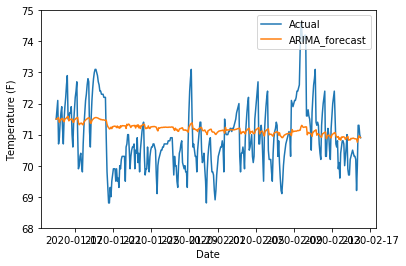

In [61]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,label='Actual')
plt.plot(predictions_ARIMA,label='ARIMA_forecast')
plt.legend(loc="upper right")
plt.ylim(68,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

In [62]:
print('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

RMSE: 1.0226
